<b> Introduction <b>

Puerto Rico, known as a region susceptible to natural disasters, particularly hurricanes, faces significant challenges due to its tropical climate and island geography. The impacts of these disasters on the local population, infrastructure, and ecosystems are profound and often devastating. For example Hurricane Maria, caused catastrophic damages and an important humanitarian crisis, most of the population in the island suffered floods and lack of resources. In response to this, our team is using advanced Machine Learning models to identify areas at high risk of flooding. This initiative aims to provide early warnings to residents, enabling them to take essential precautions. By accurately predicting flood-prone zones, we can guide community members to safety and strategically mitigate the risk of casualties, thereby enhancing disaster preparedness and response efforts across the island.

<B>Pre- and Post-Event NDVI Analysis<B>

In [6]:
##Pre-modeling libraries

#Supressing warnings
import warnings

#Ignoring all warnings
warnings.filterwarnings('ignore')

#Importing GIS tools
import numpy                   as np
import xarray                  as xr
import matplotlib.pyplot       as plt
import rasterio.features
import rioxarray               as rio
from matplotlib.cm import RdYlGn, Reds

#Importing Planetary Computer tools
import pystac_client
import planetary_computer as pc
import odc
from odc.stac import stac_load

#Importing datetime functions
from datetime import date # date-related calculations

##Modeling libraries

#GeoTiff images
import rasterio
from   osgeo import gdal


#Importing data visualization libraries
from   matplotlib.pyplot import figure
import matplotlib.image  as img
from   PIL               import Image


#Importing libraries for model buildings
import ultralytics
from   ultralytics import YOLO
import labelme2yolo


#Other libraries
import os
import shutil
import zipfile


In [2]:
## Hurricane Maria - San Juan, Puerto Rico ##

#Defining the bounding box for the entire data region 
min_lon = -66.19385887
min_lat =  18.27306794
max_lon = -66.08007533
max_lat =  18.48024350


#Setting geographic boundary
bounds = (min_lon, min_lat, max_lon, max_lat)


#Setting time window
time_window = "2017-03-31/2018-01-01"

In [3]:
#Connecting to the planetary computer
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")


#Seaching for data
search = stac.search(collections = ["sentinel-2-l2a"],
                     bbox        = bounds,
                     datetime    = time_window)


#Instantiating results list
items = list(search.get_all_items())

In [4]:
#Pixel resolution for the final product
resolution = 10  # meters per pixel 


#Scaling to degrees per pizel
scale = resolution / 111320.0 # degrees per pixel for CRS:4326 

In [5]:
#Stablishing xx
xx = stac_load(
    items,
    bands      = ["red", "green", "blue", "nir", "SCL"],
    crs        = "EPSG:4326",                            # latitude-longitude
    resolution = scale,                                  # degrees
    chunks     = {"x": 2048, "y": 2048},
    dtype      = "uint16",
    patch_url  = pc.sign,
    bbox       = bounds
)

In [6]:
#Instantiating a colormap for SCL pixel classifications

scl_colormap = np.array(
    [
        [252,  40, 228, 255],  # 0  - NODATA - MAGENTA
        [255,   0,   4, 255],  # 1  - Saturated or Defective - RED
        [0  ,   0,   0, 255],  # 2  - Dark Areas - BLACK
        [97 ,  97,  97, 255],  # 3  - Cloud Shadow - DARK GREY
        [3  , 139,  80, 255],  # 4  - Vegetation - GREEN
        [192, 132,  12, 255],  # 5  - Bare Ground - BROWN
        [21 , 103, 141, 255],  # 6  - Water - BLUE
        [117,   0,  27, 255],  # 7  - Unclassified - MAROON
        [208, 208, 208, 255],  # 8  - Cloud - LIGHT GREY
        [244, 244, 244, 255],  # 9  - Definitely Cloud - WHITE
        [195, 231, 240, 255],  # 10 - Thin Cloud - LIGHT BLUE
        [222, 157, 204, 255],  # 11 - Snow or Ice - PINK
    ],
    dtype="uint8",
)

In [7]:
#Filtering out water, etc.
filter_values = [0, 1, 3, 6, 8, 9, 10]

#Defining cloud mask for filter values
cloud_mask = ~xx.SCL.isin(filter_values) 

In [8]:
#Applying cloud mask to filter out water, clouds and cloud shadows

# storing as 16-bit integers
cleaned_data = xx.where(cloud_mask).astype("uint16")

In [9]:
#Preparing two time steps compare NDVI outputs
first_time  = 0  # 
second_time = 38 # 
first_time_2 = 11
second_time_2 = 30
first_time_3 = 18
second_time_3 = 39

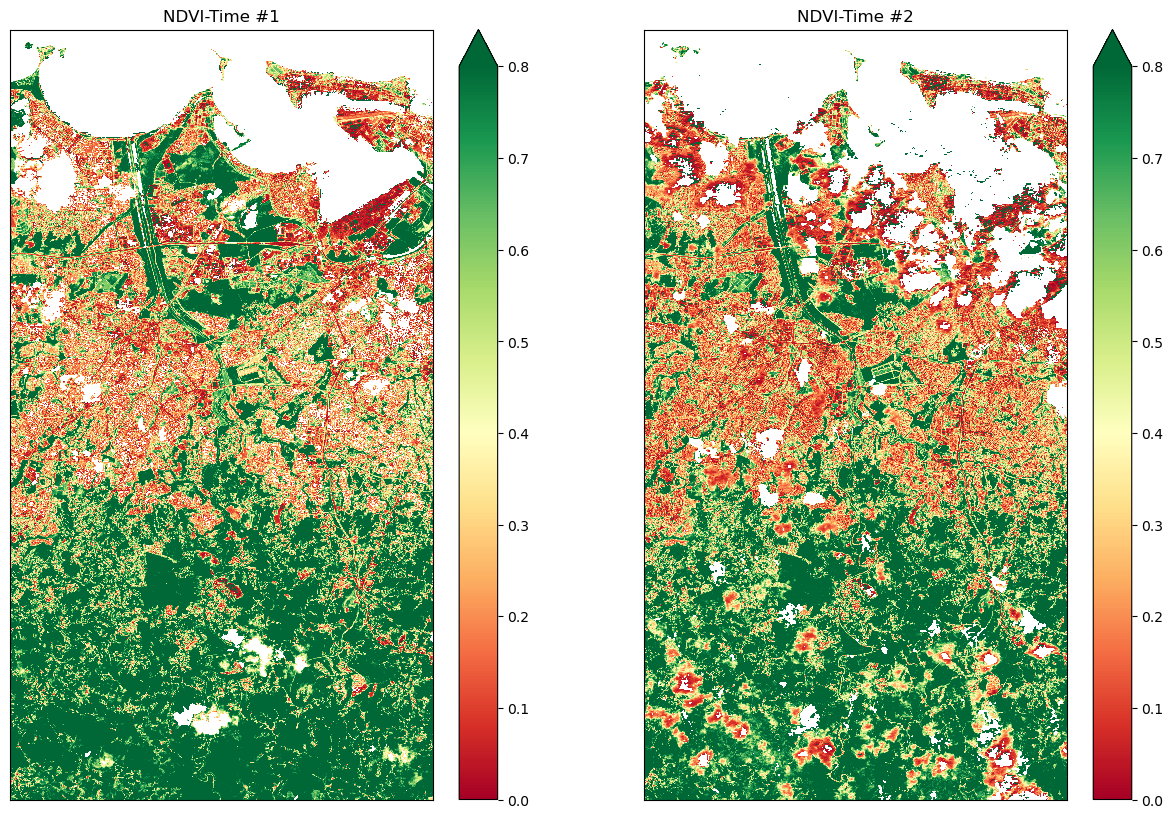

In [10]:
#Plots of NDVI at two different time slices (1)

#Setting figure size
fig, ax = plt.subplots(1, 2, figsize = (15, 10))


#First image data
ndvi_image = (cleaned_data.nir - cleaned_data.red) / (cleaned_data.nir + cleaned_data.red)
ndvi_image.isel(time = first_time ).plot(ax = ax[0],
                                         vmin = 0.0,
                                         vmax = 0.8,
                                         cmap = "RdYlGn")


#Second image data
ndvi_image.isel(time = second_time).plot(ax = ax[1],
                                         vmin = 0.0,
                                         vmax = 0.8,
                                         cmap = "RdYlGn")


#Axis labels
ax[0].set_title(label = 'NDVI-Time #1'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title(label = 'NDVI-Time #2'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)


#Showing the plot
plt.show()

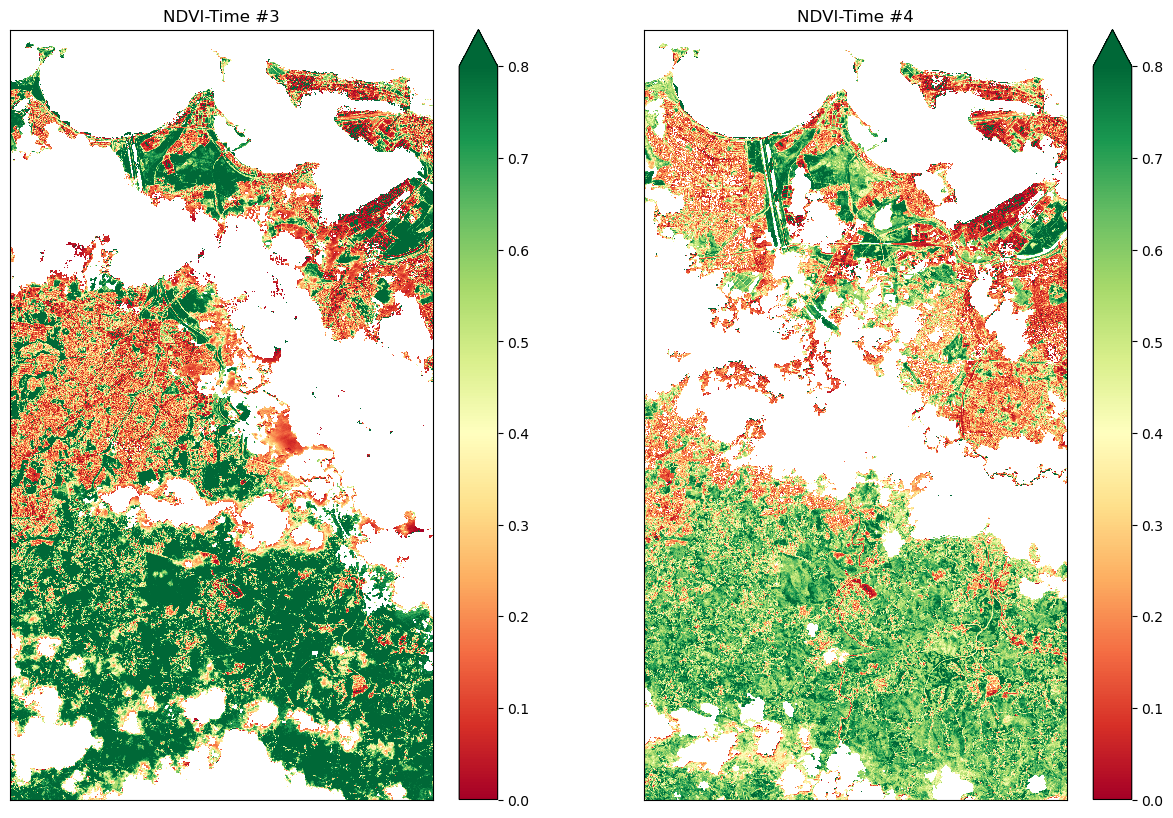

In [11]:
#Plots of NDVI at two different time slices (2)

#Setting figure size
fig, ax = plt.subplots(1, 2, figsize = (15, 10))

#Third image data
ndvi_image = (cleaned_data.nir - cleaned_data.red) / (cleaned_data.nir + cleaned_data.red)
ndvi_image.isel(time = first_time_2 ).plot(ax = ax[0],
                                         vmin = 0.0,
                                         vmax = 0.8,
                                         cmap = "RdYlGn")


#Fourth image data
ndvi_image.isel(time = second_time_2).plot(ax = ax[1],
                                         vmin = 0.0,
                                         vmax = 0.8,
                                         cmap = "RdYlGn")

#Axis labels
ax[0].set_title(label = 'NDVI-Time #3'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title(label = 'NDVI-Time #4'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)


#Showing the plot
plt.show()

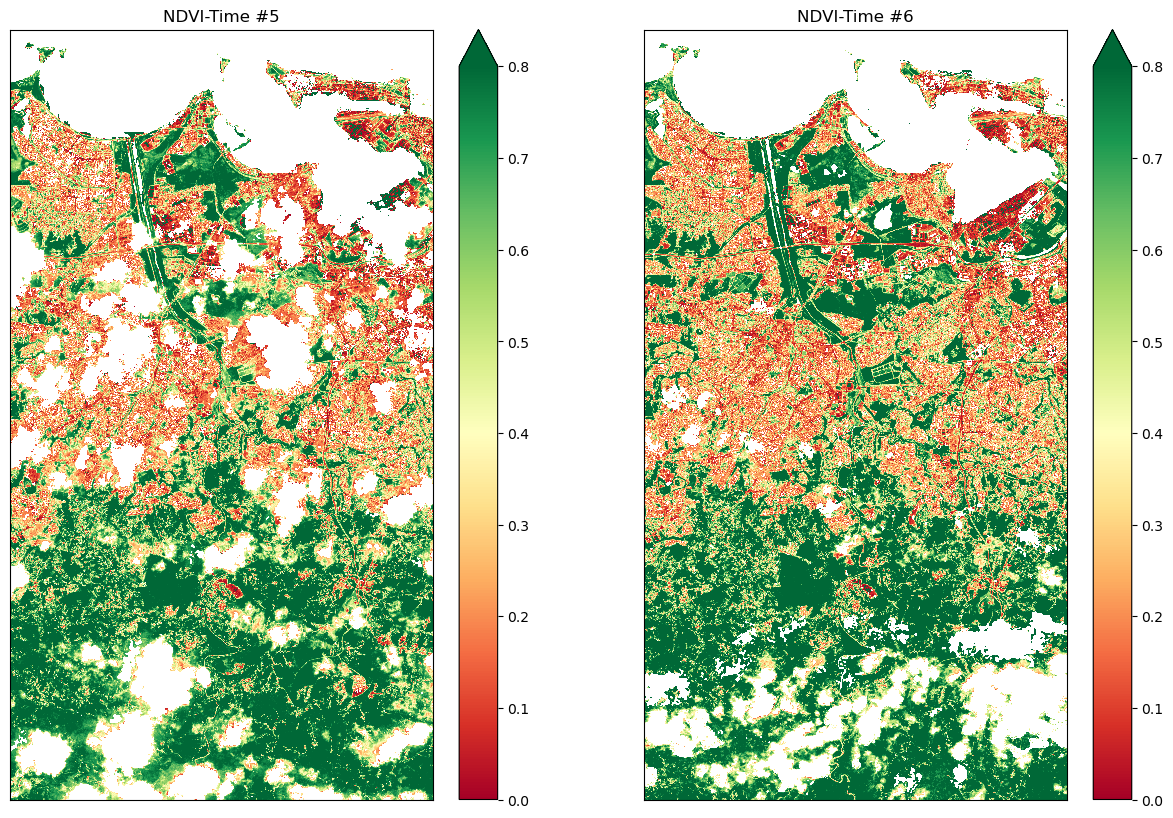

In [12]:
#Plots of NDVI at two different time slices (3)

#Setting figure size
fig, ax = plt.subplots(1, 2, figsize = (15, 10))

#Fifth image data
ndvi_image = (cleaned_data.nir - cleaned_data.red) / (cleaned_data.nir + cleaned_data.red)
ndvi_image.isel(time = first_time_3 ).plot(ax = ax[0],
                                         vmin = 0.0,
                                         vmax = 0.8,
                                         cmap = "RdYlGn")


#Sixth image data
ndvi_image.isel(time = second_time_3).plot(ax = ax[1],
                                         vmin = 0.0,
                                         vmax = 0.8,
                                         cmap = "RdYlGn")

#Axis labels
ax[0].set_title(label = 'NDVI-Time #5'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title(label = 'NDVI-Time #6'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)


#Showing the plot
plt.show()

In [13]:
#Function for calculating NDVI anomalies
def NDVI(dataset):
    return (dataset.nir - dataset.red) / (dataset.nir + dataset.red)

In [14]:
#Running comparison
ndvi_clean = NDVI(cleaned_data)

In [15]:
#Calculating difference (1)
ndvi_pre     = ndvi_clean.isel(time = first_time)
ndvi_post    = ndvi_clean.isel(time = second_time)
ndvi_anomaly = ndvi_post - ndvi_pre


#All areas of water or clouds will be black
RdYlGn.set_bad('black',1.)


#Reversing the colormap for reds
Reds_reverse = "Reds_r"

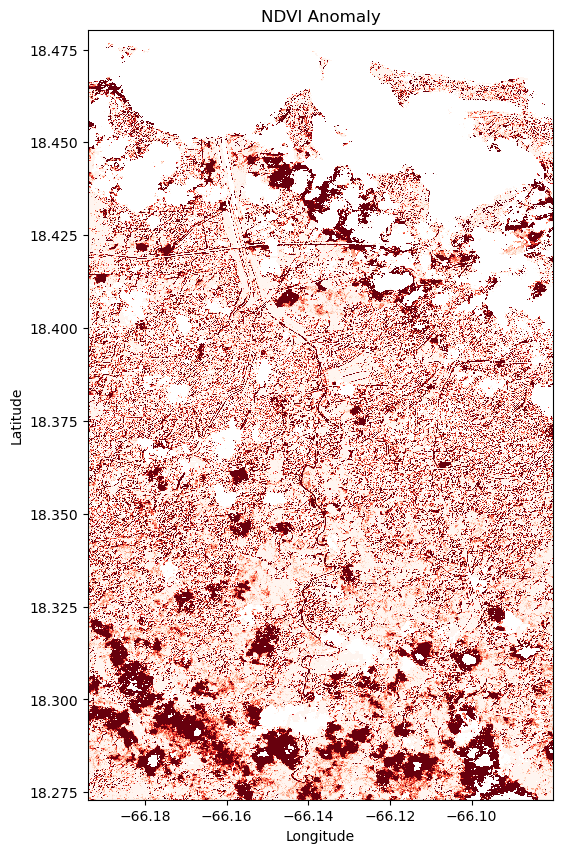

In [16]:
##Plotting NDVI anomaly (1)
plt.figure( figsize = (6,10) )
ndvi_anomaly.plot(vmin = -0.2, vmax=0.0, cmap = Reds_reverse, add_colorbar=False)


#Titles and labels
plt.title (label  = "NDVI Anomaly")
plt.xlabel(xlabel = "Longitude")
plt.ylabel(ylabel = "Latitude")


#Showing the plot
plt.show()

In [17]:
#Calculating difference (2)
ndvi_pre     = ndvi_clean.isel(time = first_time_2)
ndvi_post    = ndvi_clean.isel(time = second_time_2)
ndvi_anomaly = ndvi_post - ndvi_pre


#All areas of water or clouds will be black
RdYlGn.set_bad('black',1.)


#Reversing the colormap for reds
Reds_reverse = "Reds_r"

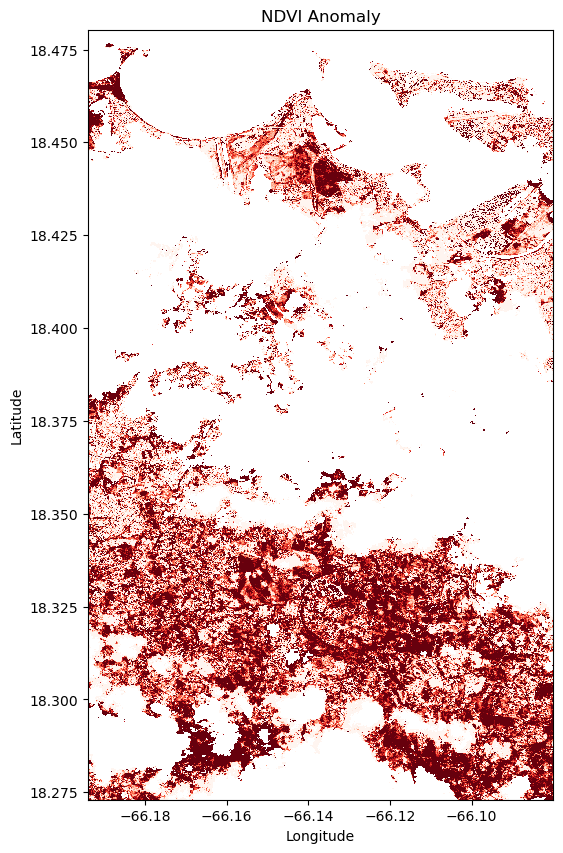

In [18]:
##Plotting NDVI anomaly (2)
plt.figure( figsize = (6,10) )
ndvi_anomaly.plot(vmin = -0.2, vmax=0.0, cmap = Reds_reverse, add_colorbar=False)


#Titles and labels
plt.title (label  = "NDVI Anomaly")
plt.xlabel(xlabel = "Longitude")
plt.ylabel(ylabel = "Latitude")


#Showing the plot
plt.show()

In [19]:
#Calculating difference (3)
ndvi_pre     = ndvi_clean.isel(time = first_time_3)
ndvi_post    = ndvi_clean.isel(time = second_time_3)
ndvi_anomaly = ndvi_post - ndvi_pre


#All areas of water or clouds will be black
RdYlGn.set_bad('black',1.)


#Reversing the colormap for reds
Reds_reverse = "Reds_r"

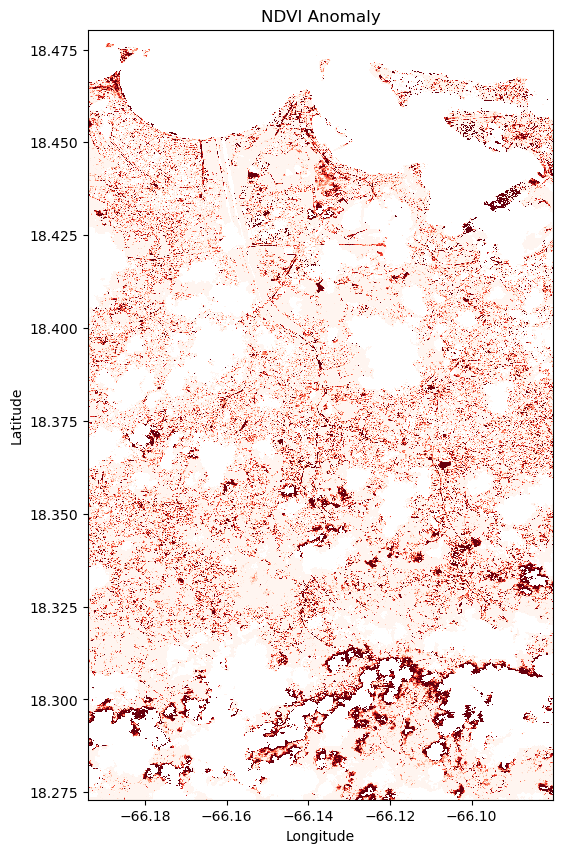

In [20]:
##Plotting NDVI anomaly (3)
plt.figure( figsize = (6,10) )
ndvi_anomaly.plot(vmin = -0.2, vmax=0.0, cmap = Reds_reverse, add_colorbar=False)


#Titles and labels
plt.title (label  = "NDVI Anomaly")
plt.xlabel(xlabel = "Longitude")
plt.ylabel(ylabel = "Latitude")


#Showing the plot
plt.show()

<b> Actionable Recommendations <b>

The first actionable recommendation is to increase funds for the “Asistencia para la Mitigación de Riesgos” (FEMA), a public program dedicated to mitigating losses during natural disasters. It would aim to incentivize the allocation of monetary resources to effectively carry out evacuations plans and ensure the availability of motivated personnel. By offering incentives within the program, individuals would be encouraged to prioritize evacuation preparedness. Such a program is intended to foster a culture of readiness and proactive response to potential emergencies or disasters. The objective of the program is to enhance state presence and strengthen community cooperation. (Gobierno de Puerto Rico)


The second actionable recommendation, directly tied with the first one, would be to establish an evacuation plan and gather emergency supplies. The purpose is to lead the residents that live near the coastline and areas at risk of river overflows to relocate in areas which are not directly affected by a sudden rise of sea-levels and firmer land. These areas are found along the city outskirts and appear less affected by the hurricane in general, but essential supplies such as drinkable water and food are not readily available. Determining accessible routes is an important aspect of this plan. In many cases, people reside in areas that would have immediate access to water, which makes this effort a priority. It is expected that introducing more preparedness strategies to the community will help reduce mental and physical detriment after the event, as seen by Joshipura et al. (2022)


Thirdly, as a consequence of the second actionable recommendation, it's crucial to spread the word about hurricane dangers. Whether through radio ads, social media or community outreach, getting the message out there is essential. Many people don't realize just how serious hurricanes can be, so educating them about the risks is key. This way, when evacuation plans spring into action, people will understand why it's so important to follow them. It's all about making sure everyone's on the same page when it comes to staying safe during a storm. Social media has proved to be an invaluable tool for communication during and after a natural disaster as studied by Bacon & Mujkic (2016), helping nonprofit organizations to act immediately providing the necessary assistance.

<b>Object Detection (Image Labeling)<b>

Image labeling was done using Label me, 25 pre-event images and 25 post-event images where labeled and saved into the "manually labeled" folder. These images were not used to train the model, instead we utilized a dataset from roboflow, the reference for it an be found in the README text files inside the zip file. The images downloaded from roboflow are most likely the results of another object detection model, given that some images are missing some clear labels and others have backgrounds labeled as buildings. The data set also used a different approach from ours to label the pictures, using rectangles that incorporate some of the background into them, while we used the manual tool to trace the edges of the buildings without incorporating the surroundings. Although the labeling in these images is not perfect it significantly improved our mAP score.

<b>Model Building<b>

In [7]:
#Loading the model
model = YOLO('yolov8n.pt')

In [ ]:
#Hyperparameter Tuning (This step was done using an External GPU so the outputs are not visible in this notebook)

#model.tune(data='/Users/juanmanumango/Desktop/Hult/Business Challenege III/Model/data.yaml', epochs=50, iterations=60, optimizer='SGD', val=False)

In [8]:
# Train the model on the dataset for 50 epochs (With best params from tuning)
results = model.train(data = './data.yaml',
                      seed            = 702,     #Seed to replicate results
                      imgsz           = 640,     #Image size
                      epochs          = 50,      #Number of epochs
                      optimizer       = 'SGD',    
                      lr0             = 0.00922, #Critical 
                      lrf             = 0.00707,
                      momentum        = 0.98,
                      weight_decay    = 0.00052,
                      warmup_epochs   = 3.0281,
                      warmup_momentum = 0.95,
                      box             = 8.78755, #Might improve mAP score
                      cls             = 0.44802, #Same
                      dfl             = 1.64183,
                      hsv_h           = 0.00859, #For different lighting
                      hsv_s           = 0.79619,
                      hsv_v           = 0.38164,
                      degrees         = 0.0,     #For objectives in different angles
                      translate       = 0.13664,
                      scale           = 0.33876, 
                      shear           = 0.0,
                      perspective     = 0.0,
                      flipud          = 0.0,
                      fliplr          = 0.40009,
                      bgr             = 0.0,
                      mosaic          = 0.87205, #Default 1
                      mixup           = 0,       #Thought this would be useful
                      copy_paste      = 0
                      )

New https://pypi.org/project/ultralytics/8.2.4 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.0 🚀 Python-3.11.8 torch-2.2.2 CPU (Apple M2)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train63, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=702, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_c

train: Scanning /Users/juanmanumango/Desktop/A1_Team2/labels/train... 200 images

train: New cache created: /Users/juanmanumango/Desktop/A1_Team2/labels/train.cache



val: Scanning /Users/juanmanumango/Desktop/A1_Team2/labels/val... 55 images, 0 b

val: New cache created: /Users/juanmanumango/Desktop/A1_Team2/labels/val.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 192, len(boxes) = 914. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to /Users/juanmanumango/runs/detect/train63/labels.jpg... 
optimizer: SGD(lr=0.00922, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00052), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/juanmanumango/runs/detect/train63
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      2.042      3.722      1.912        697        640:  


KeyboardInterrupt: 

The model was also ran using the external GPU to see the outputs of this model please refer to the SGD.ipynb file. Nevertheless the model should still run without any issues using a small sample of the bigger dataset used in our actual model. 

<b> Model Analysis <b>

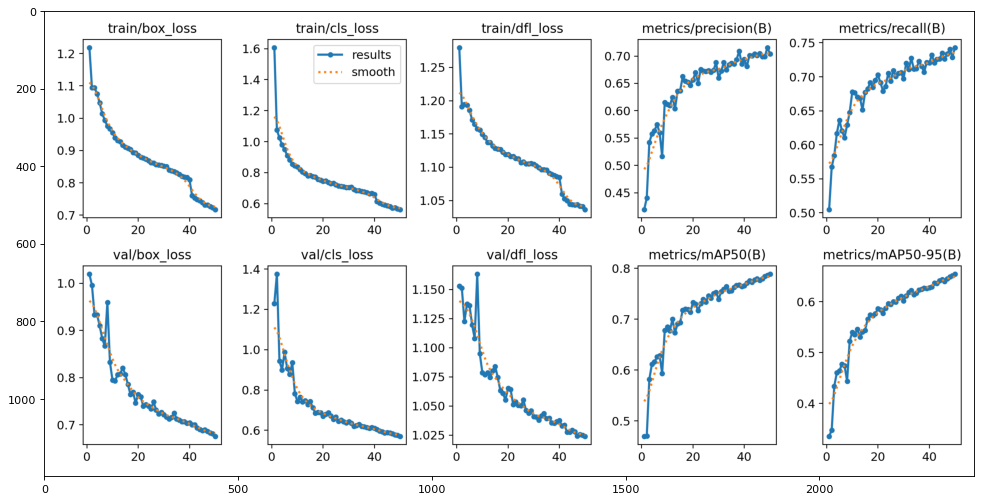

In [3]:
#Plotting model results

figure(figsize=(15, 10), dpi=80)
# reading the image 
results = img.imread(fname = './train124/results.png', format = 'png') # change this as needed
# displaying the image 
plt.imshow(results)
#plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

The results for the model where excellent, the best mAP score ended up being 0.789 (This can be seen in the SGD.ipynb file). This was mainly due to the quality of our data. The dataset downloaded from roboflow provided us with a large amount of training data that was labeled almost perfectly. This was the biggest factor in improving our score. Hyperparemeter tuning ended up not being as significant as we would have expected, only improving our model by less than 10%. With more time, we could executed a better tuning process that might have significantly improved our model. 

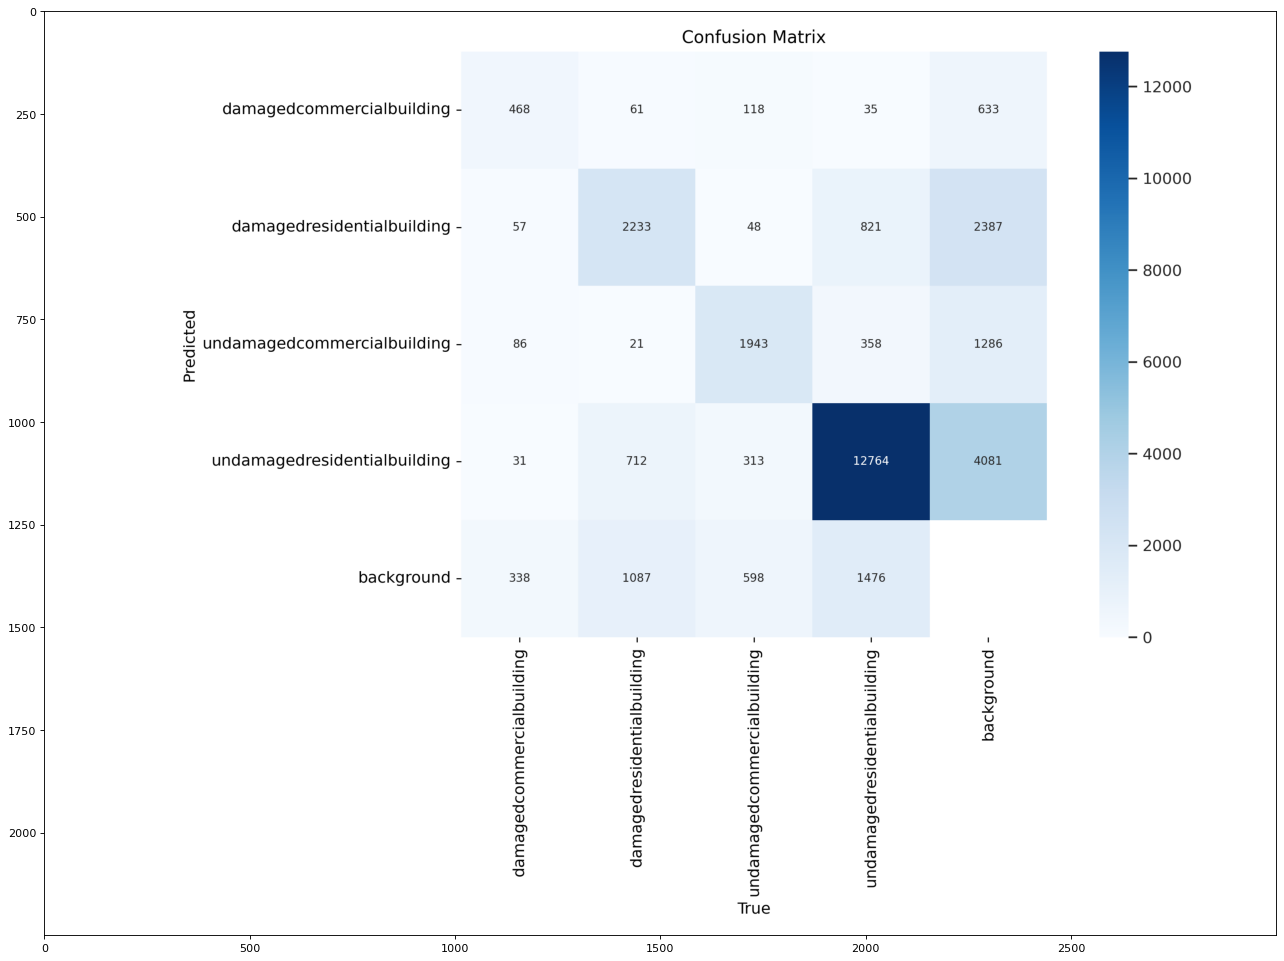

In [4]:
#Plotting confusion matrix

figure(figsize=(20,15), dpi=80)  
# reading the image 
cf = img.imread('./train124/confusion_matrix.png') # change this as needed
# displaying the image 
plt.imshow(cf)
plt.show()

Looking at the confusion matrix we can observe the areas of improvement in the model. Overall the predictions were good but there were a lot of background points that were labeled as buildings. In addition, there are a couple of false predictions regarding residential buildings. Adjusting class weights to be less sensitive would improve our precision score and therefore improve our mAP score. 

<b>Making Predictions on the Submission Data<b>

In [52]:
#Loading best model
model = YOLO('./train124/weights/best.pt') # change this as needed

In [54]:
# # Decoding according to the .yaml file class names order
# decoding_of_predictions ={0: 'undamagedcommercialbuilding', 1: 'undamagedresidentialbuilding', 2: 'damagedresidentialbuilding', 3: 'damagedcommercialbuilding'}

# directory = './Submission Data (12 images)'
# # Directory to store outputs
# results_directory = 'Validation_Data_Results'

# # Create submission directory if it doesn't exist
# if not os.path.exists(results_directory):
#     os.makedirs(results_directory)

# # Loop through each file in the directory
# for filename in os.listdir(directory):
#     # Check if the current object is a file and ends with .jpeg
#     if os.path.isfile(os.path.join(directory, filename)) and filename.lower().endswith('.jpg'):
#         # Perform operations on the file
#         file_path = os.path.join(directory, filename)
#         print(file_path)
#         print("Making a prediction on ", filename)
#         results = model.predict(file_path, save=True, iou=0.5, save_txt=True, conf=0.25)
        
#         for r in results:
#             conf_list = r.boxes.conf.numpy().tolist()
#             clss_list = r.boxes.cls.numpy().tolist()
#             original_list = clss_list
#             updated_list = []
#             for element in original_list:
#                  updated_list.append(decoding_of_predictions[int(element)])

#         bounding_boxes = r.boxes.xyxy.numpy()
#         confidences = conf_list
#         class_names = updated_list

#         # Check if bounding boxes, confidences and class names match
#         if len(bounding_boxes) != len(confidences) or len(bounding_boxes) != len(class_names):
#             print("Error: Number of bounding boxes, confidences, and class names should be the same.")
#             continue
#         text_file_name = os.path.splitext(filename)[0]
#         # Creating a new .txt file for each image in the submission_directory
#         with open(os.path.join(results_directory, f"{text_file_name}.txt"), "w") as file:
#             for i in range(len(bounding_boxes)):
#                 # Get coordinates of each bounding box
#                 left, top, right, bottom = bounding_boxes[i]
#                 # Write content to file in desired format
#                 file.write(f"{class_names[i]} {confidences[i]} {left} {top} {right} {bottom}\n")
#         print("Output files generated successfully.")


./Submission Data (12 images)/Validation_Post_Event_009.jpg
Making a prediction on  Validation_Post_Event_009.jpg

image 1/1 /Users/juanmanumango/Desktop/A1/Submission Data (12 images)/Validation_Post_Event_009.jpg: 640x640 6 damagedcommercialbuildings, 5 damagedresidentialbuildings, 12 undamagedcommercialbuildings, 9 undamagedresidentialbuildings, 88.9ms
Speed: 4.5ms preprocess, 88.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /Users/juanmanumango/runs/detect/predict3
12 labels saved to /Users/juanmanumango/runs/detect/predict3/labels
Output files generated successfully.
./Submission Data (12 images)/Validation_Post_Event_008.jpg
Making a prediction on  Validation_Post_Event_008.jpg

image 1/1 /Users/juanmanumango/Desktop/A1/Submission Data (12 images)/Validation_Post_Event_008.jpg: 640x640 2 damagedcommercialbuildings, 7 damagedresidentialbuildings, 2 undamagedcommercialbuildings, 14 undamagedresidentialbuildings, 76.0ms
Speed: 1.6ms preprocess

The submission results can be found in the zip file as under the "Best Model Results" folder.

<b> Conclusion <b>

After finishing this project, the most notorious insights that we encountered were as follows:

1. According the National Oceanic and Atmospheric Administration, within an 18 hour period, Hurricane Maria became a category 5 hurricane. This rapid intensification highlights the need for swift response mechanisms in hurricane-prone regions.

2. Based on the findings on our code, the buildings in San Juan that suffered the most damage were commercial. Of a total of 14,997 residential buildings and 2,411 comercial buildings, 14% of residential buildings were damaged and 19% of commercial buildings were damaged. This shows the vulnerability of infrastructure and the need for robust building codes and construction practices within the area.

3. As reported by RAND Puerto Rico’s municipal governments were unprepared for a disaster of this magnitude. This lack of preparedness shows the effects of the hurricane and hindered effective response and recovery efforts.

Based on these insights, our team proposes several actionable recommendations to enhance disaster preparedness and response in Puerto Rico. These include refining the existing evacuation plans to be more region-specific, which would allow for more targeted and efficient evacuations. Also, we suggest implementing area-specific disaster management plans that address the unique needs and vulnerabilities of different regions and their people. As a final recommendation, an educational program should be established to raise awareness about disaster preparedness and provide training on how to effectively respond to emergencies. Such initiatives are crucial for building resilience and ensuring a more robust response to future natural disasters. By implementing these strategies, we believe Puerto Rico can better safeguard its communities and infrastructure against the inevitable challenges posed by future storms.

<b> Steps we would take to improve the model if we had more time <b>

<b>Enhance data collection: <b>

We would expand our data collection efforts to include not only NDVI but also other relevant indices like soil moisture and land surface temperature. This would provide a more comprehensive dataset for analysis, allowing for better predictions and insights into the effects of hurricanes on different types of terrain and vegetation.


<b>Refine our predictive model: <b>
  
The main challenge for us was getting used to the tools and methods necessary for this assignment. Learning how to utilize external GPU's and to use completely new functions to us such as YOLO required a lot of time practicing and understanding. With more time we believe we could have done a much better job tuning our model. Using tools such as ray tune, which we didn't manage to get working properly, could have substantially improved our model's performance. 
    
Adjusting class weights is another improvement we believe would critically increase our score, making the model less sensitive towards some classes would lead to more accurate predictions. If we counted with more time we are confident we could have added this feature to our model. 

Apart from these more technical improvements if we counted with 3 months to work on this project the ideal situation would have been to manually label more images and use those instead of the roboflow dataset. Although the dataset we found seems to be good enough, we would have prefer to do this work ourselves to prevent any mistakes or error the people who developed the dataset might have committed. 


<b> Build partnerships: <b>
    
We would strengthen our ties with local governments, non-governmental organizations, and community leaders. These partnerships would be key in turning our data into actionable plans that can directly benefit the people most at risk.

<b>Bibliography<b>

Bacon Brengarth, L., & Mujkic, E. (2016). WEB 2.0: How social media applications leverage nonprofit responses during a wildfire crisis. Computers in Human Behavior, 54, 589-596. https://doi.org/10.1016/j.chb.2015.07.010.

Joshipura, K. J., Martínez-Lozano, M., Ríos-Jiménez, P. I., Camacho-Monclova, D. M., Noboa-Ramos, C., Alvarado-González, G. A., & Lowe, S. R. (2022). Preparedness, hurricanes Irma and Maria, and impact on health in Puerto Rico. International Journal of Disaster Risk Reduction, 67, 102657.

Gobierno de Puerto Rico. (n.d.). Mitigación de riesgos. Recuperación de Puerto Rico. https://recovery.pr.gov/es/recovery-programs/hazard-mitigation-assistance

Rand Corporation. (2018). Hurricanes Irma and Maria: Impact and Aftermath. Www.rand.org. https://www.rand.org/hsrd/hsoac/projects/puerto-rico-recovery/hurricanes-irma-and-maria.html

US Department of Commerce, NOAA, National Weather Service. (2017, September 20). Major Hurricane Maria - September 20, 2017. Weather.gov. https://www.weather.gov/sju/maria2017

<b> Feedback for EY <b>

The challenge at hand was a very interesting one that we would've loved to explore more without such a harsh time constraint. As a team, we found it very appealing to work with object detection even if it was completely new to all of us. If we were to mention an improvement, it would be to try optimizing model training by adjusting epochs and adopting transfer learning can significantly reduce runtime. Also, in our case, we would like to explore with more object detection tools, maybe focus on different types of building depending on the area, and using classes for them to decide on the level of damage and urgency of repair. This would definitely reduce the scope to put focus on the structures that are more dangerous and need more of an immediate assistance. 


Besides this, we enjoyed a lot working with satellite imagery, as being completely hands on with what we were doing. It gave us a feeling of acting with a global purpose for the greater good. In summary, while we faced time constraints and the challenge of adopting new technologies, our team's commitment to innovation and social impact has only grown stronger. We look forward to refining our approach, furthering our technical capabilities, and continuing to contribute to meaningful projects with significant global relevance.